In [12]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## CCLE BROAD 2019

In [13]:

DATA_DIR = "../data/ccle/ccle_broad_2019"
EXPR_FILE = f"{DATA_DIR}/data_mrna_seq_rpkm.txt"
META_EXPR_FILE = f"{DATA_DIR}/meta_mrna_seq_rpkm.txt"
META_STUDY_FILE = f"{DATA_DIR}/meta_study.txt"
MUTATIONS_FILE=f"{DATA_DIR}/data_mutations.txt"


In [15]:
# # 3. Load Data
# Read the expression matrix and metadata into pandas DataFrames.

# Expression data (genes x cell lines)
expr = pd.read_csv(EXPR_FILE, sep='\t', index_col=0)
# Metadata for expression samples
meta_expr = pd.read_csv(META_EXPR_FILE, sep='\t', index_col=0)
# Study metadata (cell line annotations)
meta_study = pd.read_csv(META_STUDY_FILE, sep='\t', index_col=0)

#mutations file
mutations = pd.read_csv(MUTATIONS_FILE,  sep='\t', comment = '#' ,low_memory=False, index_col=0)


In [16]:
def select_mutation_columns(file_path):
    """
    Load mutations data and select only Hugo_Symbol, Tumor_Sample_Barcode, 
    Variant_Type, and Variant_Classification columns
    """
    # Read the full dataset
    df = pd.read_csv(file_path, sep='\t', comment='#', low_memory=False)
    
    # Select only the columns you need
    columns_needed = [
        'Hugo_Symbol',           # Gene symbol
        'Tumor_Sample_Barcode',  # Sample name
        'Variant_Type',          # Variant type (SNP, INS, DEL, etc.)
        'Variant_Classification' # Variant classification (Missense, Silent, etc.)
    ]
    
    # Create subset with only these columns
    df_subset = df[columns_needed].copy()
    
    return df_subset


In [17]:
expr = expr.transpose()
expr.index.name = 'Tumor_Sample_Barcode'
expr

Hugo_Symbol,DDX11L1,WASH7P,MIR1302-11,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,CICP27,AL627309.1,...,MT-ND3,MT-TR,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
22RV1_PROSTATE,0.00000,12.63011,0.04289,0.00000,0.00000,0.00000,0.00000,0.44714,0.37909,6.17780,...,1176.81189,0.00000,0.00000,0.00000,0.12335,2393.80298,1825.52332,0.25386,4923.78223,0.00000
2313287_STOMACH,0.03755,10.14155,0.01037,0.00869,0.00000,0.00000,0.00000,0.34327,0.09168,6.56648,...,1009.34979,0.00000,0.00000,0.00000,0.00000,1960.96802,2056.64697,0.00000,3827.00537,0.00000
253JBV_URINARY_TRACT,0.00000,6.20657,0.16955,0.22423,0.02886,0.01939,0.00000,0.16982,0.10995,1.03405,...,2816.78296,0.00000,0.39614,0.00000,0.51331,1896.28870,2184.88647,0.26410,1905.18481,0.00000
253J_URINARY_TRACT,0.06507,6.55835,0.23364,0.16558,0.03875,0.03904,0.00000,0.08922,0.09146,0.76888,...,7116.30469,0.14115,0.26594,0.00000,1.03378,3522.37695,4568.00195,0.00000,4590.01416,0.00000
42MGBA_CENTRAL_NERVOUS_SYSTEM,0.00000,7.61752,0.08765,0.00000,0.00000,0.00000,0.00000,0.09428,0.07513,1.01231,...,1049.68384,0.13768,0.00000,0.00000,0.25209,1178.93579,1616.96484,0.12970,2343.92407,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UMUC9_URINARY_TRACT,0.03236,8.70551,0.07747,0.00000,0.00642,0.00000,0.01325,0.02958,0.10214,0.44584,...,2820.28882,0.09360,0.00000,0.00000,0.00000,1452.41895,996.53717,0.08817,3437.12769,0.00000
UPCISCC152_UPPER_AERODIGESTIVE_TRACT,0.00000,15.23348,0.07448,0.02674,0.00000,0.00000,0.00000,0.04402,0.08265,1.91472,...,995.56390,0.16713,0.00000,0.00000,0.30602,793.58710,593.61139,0.31489,1645.22168,0.00000
UW228_CENTRAL_NERVOUS_SYSTEM,0.03799,6.47732,0.01049,0.00879,0.00000,0.02279,0.00000,0.06945,0.01686,0.21741,...,441.25647,0.16482,0.00000,0.00000,0.00000,757.41357,472.01627,0.15526,973.56439,0.16232


In [18]:
mutations

,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,Variant_Type,...,RNAseq_AC,SangerRecalibWES_AC,SangerWES_AC,TCGAhsCnt,WES_AC,WGS_AC,cDNA_Change,isCOSMIChotspot,isDeleterious,isTCGAhotspot
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
DVL1,1855,NaN,GRCh37,1,1277461,1277461,+,synonymous_variant,Silent,SNP,...,NaN,NaN,NaN,0,87:39,NaN,c.438G>A,False,False,False
AL590822.1,0,NaN,GRCh37,1,2144416,2144416,+,missense_variant,Missense_Mutation,SNP,...,NaN,NaN,NaN,0,23:43,NaN,c.604C>T,False,False,False
PLCH2,9651,NaN,GRCh37,1,2435359,2435359,+,3_prime_UTR_variant,3'UTR,SNP,...,NaN,NaN,NaN,0,9:25,NaN,NaN,False,True,False
UBE4B,10277,NaN,GRCh37,1,10177641,10177641,+,missense_variant,Missense_Mutation,SNP,...,NaN,NaN,NaN,0,13:95,NaN,c.934G>A,False,False,False
SRM,6723,NaN,GRCh37,1,11119363,11119363,+,synonymous_variant,Silent,SNP,...,NaN,NaN,NaN,0,113:57,NaN,c.207C>A,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MLLT4,4301,NaN,GRCh37,6,168366687,168366689,+,downstream_gene_variant,3'Flank,DEL,...,12:91,NaN,NaN,0,NaN,NaN,c.5198_5200delACA,False,False,False
MT-ND2,4536,NaN,37,M,4604,4605,+,NaN,Frame_Shift_Ins,INS,...,9:18,NaN,NaN,0,NaN,NaN,c.135_136insA,False,True,False
POLR3H,171568,NaN,GRCh37,22,41940458,41940459,+,upstream_gene_variant,5'Flank,INS,...,5:3,NaN,NaN,0,NaN,NaN,NaN,False,True,False


In [19]:
# Display the column names to understand the structure
print("Column names:")
print(mutations.columns.tolist())

# Filter for TP53 mutations
# The gene symbol appears to be in the 'Hugo_Symbol' column based on the data
tp53_mutations = mutations.loc['TP53']
tp53_mutations


Column names:
['Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Chromosome', 'Start_Position', 'End_Position', 'Strand', 'Consequence', 'Variant_Classification', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'dbSNP_RS', 'dbSNP_Val_Status', 'Tumor_Sample_Barcode', 'Matched_Norm_Sample_Barcode', 'Match_Norm_Seq_Allele1', 'Match_Norm_Seq_Allele2', 'Tumor_Validation_Allele1', 'Tumor_Validation_Allele2', 'Match_Norm_Validation_Allele1', 'Match_Norm_Validation_Allele2', 'Verification_Status', 'Validation_Status', 'Mutation_Status', 'Sequencing_Phase', 'Sequence_Source', 'Validation_Method', 'Score', 'BAM_File', 'Sequencer', 't_ref_count', 't_alt_count', 'n_ref_count', 'n_alt_count', 'HGVSc', 'HGVSp', 'HGVSp_Short', 'Transcript_ID', 'RefSeq', 'Protein_position', 'Codons', 'Hotspot', 'Broad_ID', 'COSMIChsCnt', 'Codon_Change', 'ExAC_AF', 'HC_AC', 'Protein_Change', 'RD_AC', 'RNAseq_AC', 'SangerRecalibWES_AC', 'SangerWES_AC', 'TCGAhsCnt', 'WES_AC', 'WGS_AC', 'cDNA_Change

,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,Variant_Type,...,RNAseq_AC,SangerRecalibWES_AC,SangerWES_AC,TCGAhsCnt,WES_AC,WGS_AC,cDNA_Change,isCOSMIChotspot,isDeleterious,isTCGAhotspot
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TP53,7157,NaN,GRCh37,17,7576854,7576854,+,"missense_variant,splice_region_variant",Missense_Mutation,SNP,...,88:33,23:50,24:52,0,30:33,18:15,c.992A>G,True,True,False
TP53,7157,NaN,GRCh37,17,7577120,7577120,+,missense_variant,Missense_Mutation,SNP,...,NaN,30:1,30:1,181,205:0,NaN,c.818G>A,True,False,True
TP53,7157,NaN,GRCh37,17,7577536,7577536,+,missense_variant,Missense_Mutation,SNP,...,249:1,23:0,17:0,19,337:0,NaN,c.745A>G,True,False,True
TP53,7157,NaN,GRCh37,17,7578492,7578492,+,stop_gained,Nonsense_Mutation,SNP,...,35:2,NaN,NaN,9,57:2,NaN,c.438G>A,True,True,True
TP53,7157,NaN,GRCh37,17,7578400,7578400,+,missense_variant,Missense_Mutation,SNP,...,NaN,23:19,23:21,7,235:260,NaN,c.530C>T,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TP53,7157,NaN,GRCh37,17,7578253,7578259,+,frameshift_variant,Frame_Shift_Del,DEL,...,22:6,NaN,NaN,9,NaN,NaN,c.590_596delTGGAAGG,True,True,True
TP53,7157,NaN,GRCh37,17,7578259,7578260,+,frameshift_variant,Frame_Shift_Ins,INS,...,22:5,NaN,NaN,5,NaN,NaN,c.589_590insCC,True,True,True
TP53,7157,NaN,GRCh37,17,7577150,7577159,+,"splice_acceptor_variant,coding_sequence_varian...",Splice_Site,DEL,...,NaN,NaN,NaN,0,NaN,NaN,c.783_788delGTAGTGGTAA,True,True,False


In [28]:
tp_53 = tp53_mutations[['Tumor_Sample_Barcode', 'Variant_Type', 'Variant_Classification']].copy().reset_index().drop(["Hugo_Symbol"], axis=1)

In [47]:
# First, let's prepare the tp_53 data by selecting unique sample information
# Since there might be multiple mutations per sample, we need to handle duplicates
tp53 = tp_53[['Tumor_Sample_Barcode', 'Variant_Type', 'Variant_Classification']].drop_duplicates().set_index("Tumor_Sample_Barcode")
tp53.index = tp53.index.str.strip()

In [48]:
expr.index = expr.index.str.strip()

In [49]:
merged_data = tp53.join(expr)

In [50]:
print(f"Data shape:{merged_data.shape}")

Data shape:(1125, 56320)


In [62]:
merged_data.dropna(axis=0)

,Variant_Type,Variant_Classification,DDX11L1,WASH7P,MIR1302-11,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND3,MT-TR,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
22RV1_PROSTATE,SNP,Missense_Mutation,0.00000,12.63011,0.04289,0.00000,0.00000,0.00000,0.00000,0.44714,...,1176.81189,0.00000,0.00000,0.00000,0.12335,2393.80298,1825.52332,0.25386,4923.78223,0.00000
A4FUK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SNP,Missense_Mutation,0.07489,8.35636,0.04137,0.00000,0.00000,0.00000,0.00000,0.23959,...,1363.00879,0.00000,0.00000,0.00000,0.29743,1311.90942,1502.63672,0.00000,1348.20288,0.00000
BICR16_UPPER_AERODIGESTIVE_TRACT,SNP,Nonsense_Mutation,0.01532,4.41212,0.04232,0.00000,0.00000,0.00000,0.00000,0.00700,...,6663.94336,0.00000,0.25047,0.00000,0.00000,7828.91504,8053.11865,0.00000,8957.24414,0.26186
BICR78_UPPER_AERODIGESTIVE_TRACT,SNP,Missense_Mutation,0.02870,10.00580,0.34881,0.09296,0.02279,0.02296,0.02351,0.09620,...,9380.01172,0.24905,0.15641,0.00000,0.22800,2512.17310,1964.63062,1.64226,5491.02344,0.32703
BICR78_UPPER_AERODIGESTIVE_TRACT,SNP,Nonsense_Mutation,0.02870,10.00580,0.34881,0.09296,0.02279,0.02296,0.02351,0.09620,...,9380.01172,0.24905,0.15641,0.00000,0.22800,2512.17310,1964.63062,1.64226,5491.02344,0.32703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OCIMY5_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,DEL,Frame_Shift_Del,0.11186,16.11228,0.12359,0.00000,0.00000,0.00000,0.00000,0.18990,...,3083.14941,0.00000,0.26125,0.00000,0.12694,3678.55737,4444.64502,0.26125,3361.07471,0.00000
SLR25_KIDNEY,INS,Frame_Shift_Ins,0.03057,7.45177,0.03378,0.00000,0.00000,0.01834,0.00000,0.04891,...,1830.21289,0.13265,0.00000,0.00000,0.00000,1623.19067,1807.69495,0.00000,2362.79346,0.00000
SNU8_OVARY,DEL,Frame_Shift_Del,0.00000,5.17000,0.06320,0.00000,0.00000,0.00000,0.00000,0.07554,...,4897.38721,0.00000,0.00000,0.48611,0.60593,3870.33228,4271.06348,0.20783,7916.48584,0.00000


In [59]:
expr.index

Index(['22RV1_PROSTATE', '2313287_STOMACH', '253JBV_URINARY_TRACT',
       '253J_URINARY_TRACT', '42MGBA_CENTRAL_NERVOUS_SYSTEM',
       '5637_URINARY_TRACT', '59M_OVARY', '639V_URINARY_TRACT',
       '647V_URINARY_TRACT', '697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
       ...
       'UMUC16_URINARY_TRACT', 'UMUC4_URINARY_TRACT', 'UMUC5_URINARY_TRACT',
       'UMUC6_URINARY_TRACT', 'UMUC7_URINARY_TRACT', 'UMUC9_URINARY_TRACT',
       'UPCISCC152_UPPER_AERODIGESTIVE_TRACT', 'UW228_CENTRAL_NERVOUS_SYSTEM',
       'Y79_AUTONOMIC_GANGLIA', 'YAMATO_SOFT_TISSUE'],
      dtype='object', name='Tumor_Sample_Barcode', length=1156)

In [51]:
print(f"Expression matrix shape: {expr.shape}")
expr.head()



Expression matrix shape: (1156, 56318)


Hugo_Symbol,DDX11L1,WASH7P,MIR1302-11,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,CICP27,AL627309.1,...,MT-ND3,MT-TR,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
22RV1_PROSTATE,0.00000,12.63011,0.04289,0.00000,0.00000,0.00000,0.0,0.44714,0.37909,6.17780,...,1176.81189,0.00000,0.00000,0.0,0.12335,2393.80298,1825.52332,0.25386,4923.78223,0.0
2313287_STOMACH,0.03755,10.14155,0.01037,0.00869,0.00000,0.00000,0.0,0.34327,0.09168,6.56648,...,1009.34979,0.00000,0.00000,0.0,0.00000,1960.96802,2056.64697,0.00000,3827.00537,0.0
253JBV_URINARY_TRACT,0.00000,6.20657,0.16955,0.22423,0.02886,0.01939,0.0,0.16982,0.10995,1.03405,...,2816.78296,0.00000,0.39614,0.0,0.51331,1896.28870,2184.88647,0.26410,1905.18481,0.0
253J_URINARY_TRACT,0.06507,6.55835,0.23364,0.16558,0.03875,0.03904,0.0,0.08922,0.09146,0.76888,...,7116.30469,0.14115,0.26594,0.0,1.03378,3522.37695,4568.00195,0.00000,4590.01416,0.0
42MGBA_CENTRAL_NERVOUS_SYSTEM,0.00000,7.61752,0.08765,0.00000,0.00000,0.00000,0.0,0.09428,0.07513,1.01231,...,1049.68384,0.13768,0.00000,0.0,0.25209,1178.93579,1616.96484,0.12970,2343.92407,0.0


In [8]:
# Count missing values per cell line
missing_per_line = expr.isna().sum(axis=0)
print(f"Missing values per cell line (max): {missing_per_line.max()}")

# Count missing values per gene
missing_per_gene = expr.isna().sum(axis=1)
print(f"Missing values per gene (max): {missing_per_gene.max()}")

print(expr.isnull().sum())

Missing values per cell line (max): 0
Missing values per gene (max): 0
22RV1_PROSTATE                          0
2313287_STOMACH                         0
253JBV_URINARY_TRACT                    0
253J_URINARY_TRACT                      0
42MGBA_CENTRAL_NERVOUS_SYSTEM           0
                                       ..
UMUC9_URINARY_TRACT                     0
UPCISCC152_UPPER_AERODIGESTIVE_TRACT    0
UW228_CENTRAL_NERVOUS_SYSTEM            0
Y79_AUTONOMIC_GANGLIA                   0
YAMATO_SOFT_TISSUE                      0
Length: 1156, dtype: int64


In [9]:
#expr = expr.dropna()    # Dropping the missing values.
#expr.count()

In [10]:
#print(expr.isnull().sum())   # After dropping the values


In [11]:
# Summary of expression values
expr.describe()

,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,UMUC16_URINARY_TRACT,UMUC4_URINARY_TRACT,UMUC5_URINARY_TRACT,UMUC6_URINARY_TRACT,UMUC7_URINARY_TRACT,UMUC9_URINARY_TRACT,UPCISCC152_UPPER_AERODIGESTIVE_TRACT,UW228_CENTRAL_NERVOUS_SYSTEM,Y79_AUTONOMIC_GANGLIA,YAMATO_SOFT_TISSUE
count,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,...,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000,56318.000000
mean,6.525219,6.346689,7.430355,8.004810,6.237096,6.512393,7.262930,7.000763,6.986219,7.407553,...,6.318131,6.614045,7.357728,7.663145,5.865894,6.734670,6.906326,5.807987,6.483467,6.374805
std,98.528064,95.635560,98.702254,199.838428,64.915604,63.488560,109.131338,74.307211,90.711499,89.790384,...,80.396365,66.056950,229.558588,182.984943,55.474345,92.876538,64.454045,52.735538,79.799364,72.494387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.010505,0.000000,0.005805,0.004390,0.000000,0.000000,0.002190,0.000970,0.000000,0.001130,...,0.007055,0.005640,0.000000,0.002350,0.007520,0.000000,0.000000,0.000000,0.003665,0.000000
75%,1.010502,0.611255,0.812658,0.722170,0.561855,0.558120,0.602012,0.760707,0.511240,0.560342,...,0.627235,0.649377,0.419680,0.488025,0.720453,0.556330,0.714647,0.582638,0.641910,0.708110
max,15661.660160,15261.750980,11931.201170,35615.902340,8594.037110,7163.490720,11937.983400,9486.361330,11872.747070,10966.658200,...,11415.719730,6635.346190,33614.156250,20666.789060,5844.840820,12011.083010,4888.172850,4039.840330,8737.099610,9543.581050


<Axes: xlabel='2313287_STOMACH'>

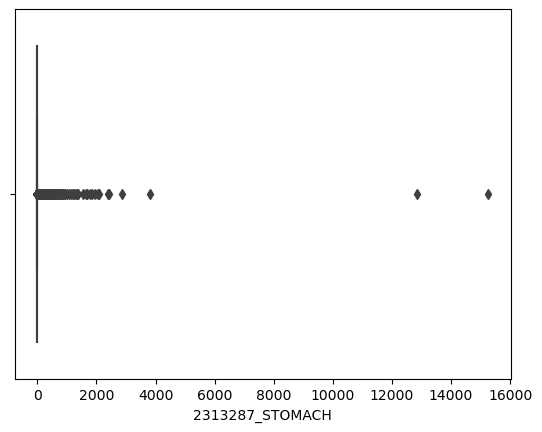

In [12]:
cnames = list(expr.columns)
cnames[1]
sns.boxplot(x=expr[cnames[1]])

<Axes: xlabel='2313287_STOMACH'>

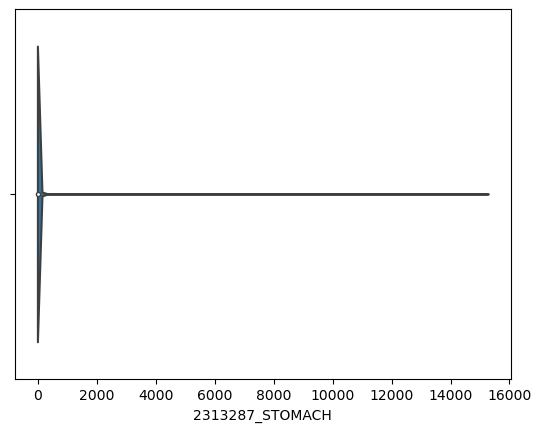

In [13]:
# Violin plots can be usefull. They are similar to a box plot, with the addition of a rotated kernel density plot on each side. So you can see the probability density of the data at different values. 
sns.violinplot(x=expr[cnames[1]])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

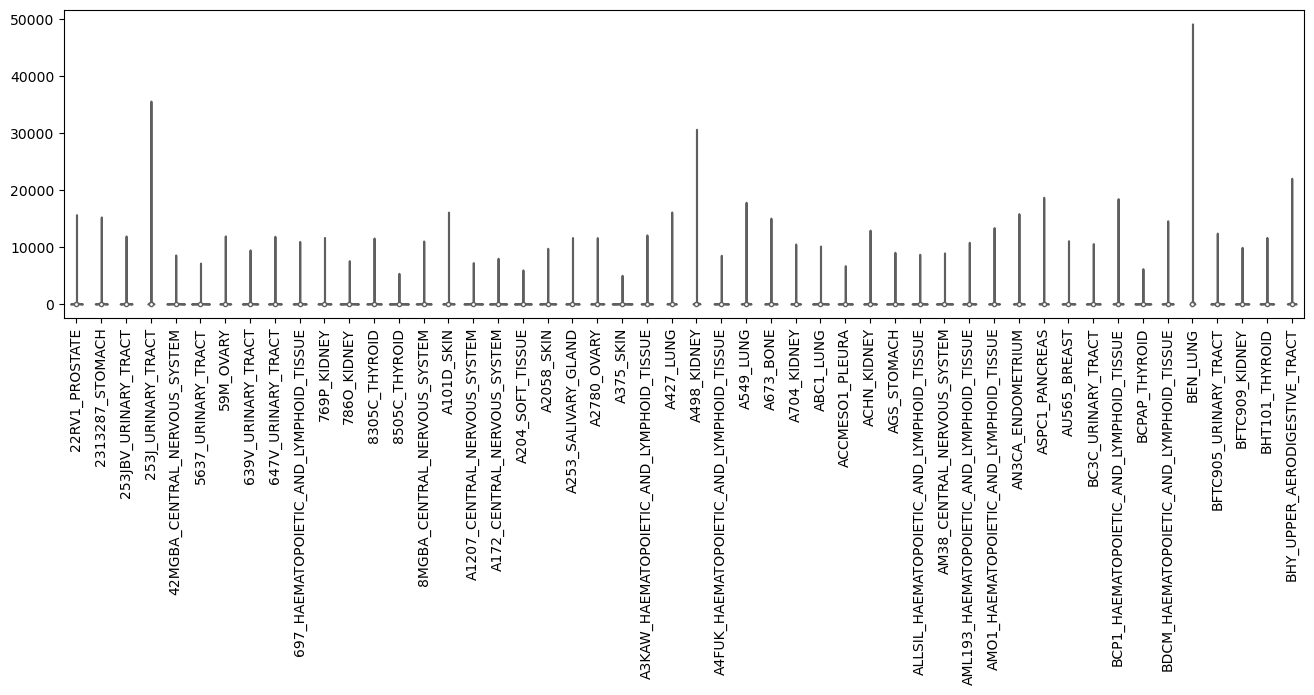

In [14]:
expr_small = expr.iloc[:, :50]
np.shape(expr_small)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=expr_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

In [15]:
Q1 = expr.quantile(0.25)
Q3 = expr.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

22RV1_PROSTATE                          1.010502
2313287_STOMACH                         0.611255
253JBV_URINARY_TRACT                    0.812658
253J_URINARY_TRACT                      0.722170
42MGBA_CENTRAL_NERVOUS_SYSTEM           0.561855
                                          ...   
UMUC9_URINARY_TRACT                     0.556330
UPCISCC152_UPPER_AERODIGESTIVE_TRACT    0.714647
UW228_CENTRAL_NERVOUS_SYSTEM            0.582638
Y79_AUTONOMIC_GANGLIA                   0.641910
YAMATO_SOFT_TISSUE                      0.708110
Length: 1156, dtype: float64


Let's try to eliminate outliers using the quantile range.
Create a new dataset. It is always tidier in EDA. You can eliminate the old one later if you are happy with your new filtered or transformed dataset.

In [16]:
expr_noOut = expr[~((expr < (Q1 - 1.5 * IQR)) |(expr > (Q3 + 1.5 * IQR))).any(axis=1)]
expr_noOut.shape
expr_noOut.head(3)

,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,UMUC16_URINARY_TRACT,UMUC4_URINARY_TRACT,UMUC5_URINARY_TRACT,UMUC6_URINARY_TRACT,UMUC7_URINARY_TRACT,UMUC9_URINARY_TRACT,UPCISCC152_UPPER_AERODIGESTIVE_TRACT,UW228_CENTRAL_NERVOUS_SYSTEM,Y79_AUTONOMIC_GANGLIA,YAMATO_SOFT_TISSUE
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.0,0.03755,0.00000,0.06507,0.0,0.01378,0.01463,0.03085,0.0,0.04487,...,0.00000,0.02977,0.02999,0.03532,0.03831,0.03236,0.0,0.03799,0.02907,0.00000
OR4G4P,0.0,0.00000,0.02886,0.03875,0.0,0.00000,0.00000,0.00000,0.0,0.00000,...,0.00667,0.01182,0.01786,0.01052,0.01141,0.00642,0.0,0.00000,0.00000,0.01459
OR4G11P,0.0,0.00000,0.01939,0.03904,0.0,0.00000,0.00000,0.00000,0.0,0.00000,...,0.00000,0.00000,0.03599,0.01590,0.00575,0.00000,0.0,0.02279,0.01163,0.01469


<Axes: xlabel='2313287_STOMACH'>

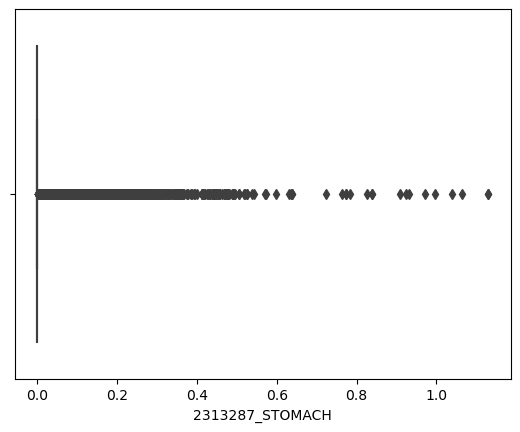

In [17]:
sns.boxplot(x=expr_noOut[cnames[1]])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

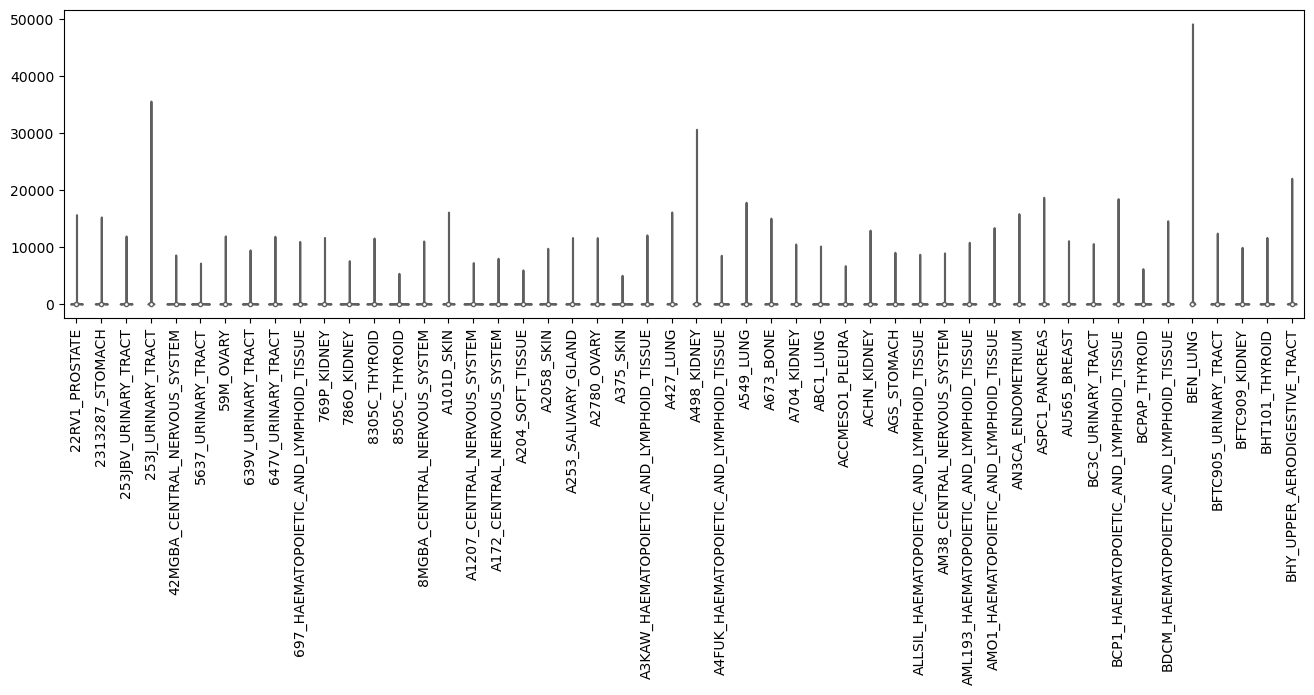

In [18]:
expr_noOut_small = expr.iloc[:, :50]
np.shape(expr_noOut_small)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=expr_noOut_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

Text(0.5, 0, 'Skewness of single cells expression profiles - original df')

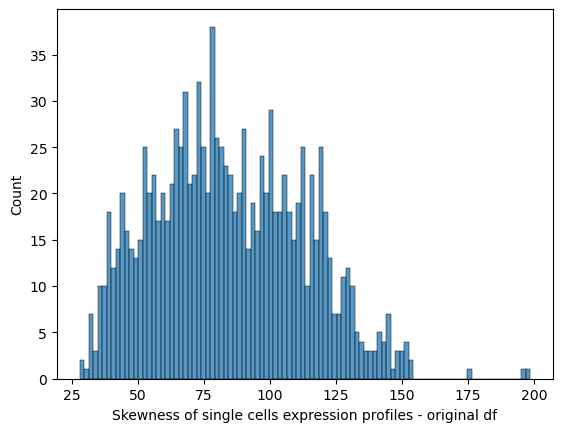

In [19]:
from scipy.stats import kurtosis, skew
colN = np.shape(expr)[1]
colN
df_skew_cells = []
for i in range(colN) :     
     v_df = expr[cnames[i]]
     df_skew_cells += [skew(v_df)]   
  #  df_skew_cells += [df[cnames[i]].skew()]
df_skew_cells
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles - original df')

Text(0.5, 0, 'Kurtosis of single cells expression profiles - original df')

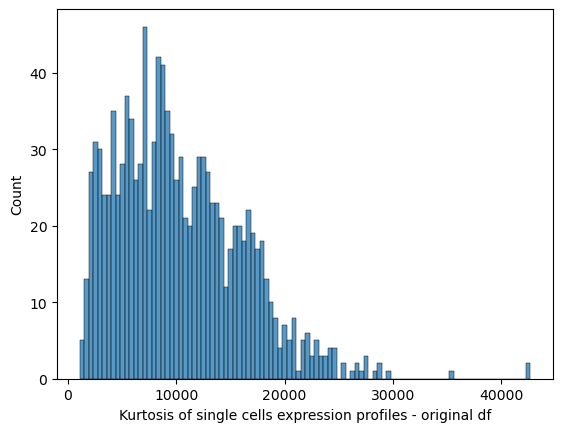

In [20]:
df_kurt_cells = []
for i in range(colN) :     
     v_df = expr[cnames[i]]
     df_kurt_cells += [kurtosis(v_df)]   
 #   df_kurt_cells += [df[cnames[i]].kurt()]
df_kurt_cells
sns.histplot(df_kurt_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles - original df')

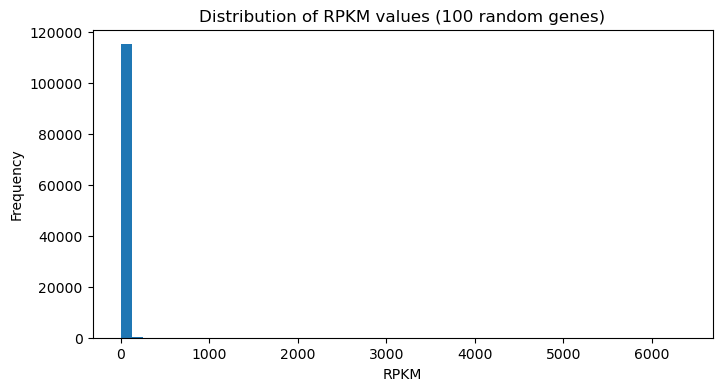

In [21]:
sampled = expr.sample(n=100, random_state=42)

# Melt the DataFrame to long format
melted = sampled.reset_index(drop=True).melt(value_name='RPKM')

plt.figure(figsize=(8, 4))
plt.hist(melted['RPKM'], bins=50)
plt.title('Distribution of RPKM values (100 random genes)')
plt.xlabel('RPKM')
plt.ylabel('Frequency')
plt.show()


In [22]:
xnorm = np.random.normal(0, 2, 10000000)   # create random values based on a normal distribution
xnorm 

print( "Excess kurtosis of normal distribution: ",  kurtosis(xnorm) )
print( "Skewness of normal distribution: ", skew(xnorm) )

Excess kurtosis of normal distribution:  0.0009721430684841437
Skewness of normal distribution:  0.0010623209303185922


Each single cell was sequenced independently, so there might be need of normalizing the data between cells. Let's plot the gene expression distributions for each cell, and compare them.

c:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


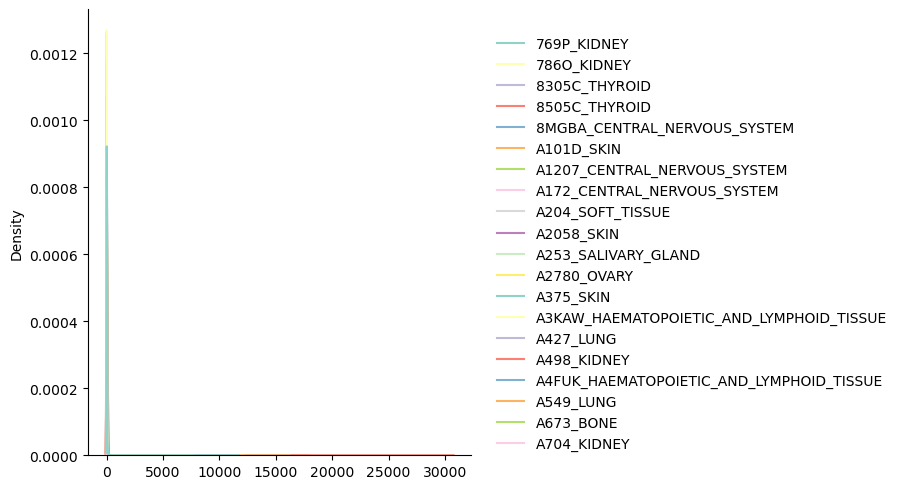

In [23]:
df_small = expr.iloc[:, 10:30]  #just selecting part of the samples so run time not too long
sns.displot(data=df_small,palette="Set3",kind="kde", bw_adjust=2)

In [24]:
df_noDup = expr.drop_duplicates()
df_noDup

,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,UMUC16_URINARY_TRACT,UMUC4_URINARY_TRACT,UMUC5_URINARY_TRACT,UMUC6_URINARY_TRACT,UMUC7_URINARY_TRACT,UMUC9_URINARY_TRACT,UPCISCC152_UPPER_AERODIGESTIVE_TRACT,UW228_CENTRAL_NERVOUS_SYSTEM,Y79_AUTONOMIC_GANGLIA,YAMATO_SOFT_TISSUE
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.00000,0.03755,0.00000,0.06507,0.00000,0.01378,0.01463,0.03085,0.00000,0.04487,...,0.00000,0.02977,0.02999,0.03532,0.03831,0.03236,0.00000,0.03799,0.02907,0.00000
WASH7P,12.63011,10.14155,6.20657,6.55835,7.61752,6.19356,4.62277,6.00767,4.70699,5.88294,...,6.42321,8.17443,7.75149,9.97036,8.17080,8.70551,15.23348,6.47732,8.45568,11.81688
MIR1302-11,0.04289,0.01037,0.16955,0.23364,0.08765,0.00000,0.00808,0.09373,0.02568,0.00826,...,0.12367,0.19183,0.10492,0.18537,0.07408,0.07747,0.07448,0.01049,0.39607,0.17586
FAM138A,0.00000,0.00869,0.22423,0.16558,0.00000,0.00637,0.00000,0.01427,0.00000,0.00000,...,0.01554,0.00459,0.01850,0.04903,0.01330,0.00000,0.02674,0.00879,0.26449,0.02266
OR4G4P,0.00000,0.00000,0.02886,0.03875,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00667,0.01182,0.01786,0.01052,0.01141,0.00642,0.00000,0.00000,0.00000,0.01459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND5,2393.80298,1960.96802,1896.28870,3522.37695,1178.93579,1345.42151,1943.89148,1413.57471,956.31226,1764.61121,...,1994.84985,704.86267,3936.23853,3560.20459,1245.38379,1452.41895,793.58710,757.41357,1218.16992,1320.84558
MT-ND6,1825.52332,2056.64697,2184.88647,4568.00195,1616.96484,1189.86279,1906.90405,1469.75574,1151.82861,1440.74084,...,1260.28455,398.13406,2419.38281,1791.45386,823.17352,996.53717,593.61139,472.01627,729.65912,564.16779
MT-TE,0.25386,0.00000,0.26410,0.00000,0.12970,0.00000,0.00000,0.25217,0.00000,0.00000,...,1.28093,0.40550,1.22567,1.58799,1.40931,0.08817,0.31489,0.15526,0.55439,0.00000


Number of cells included:  (1156, 1156)
Average correlation of expression profiles between cells:  0.5112143481191483
Min. correlation of expression profiles between cells:  0.02242869623829678


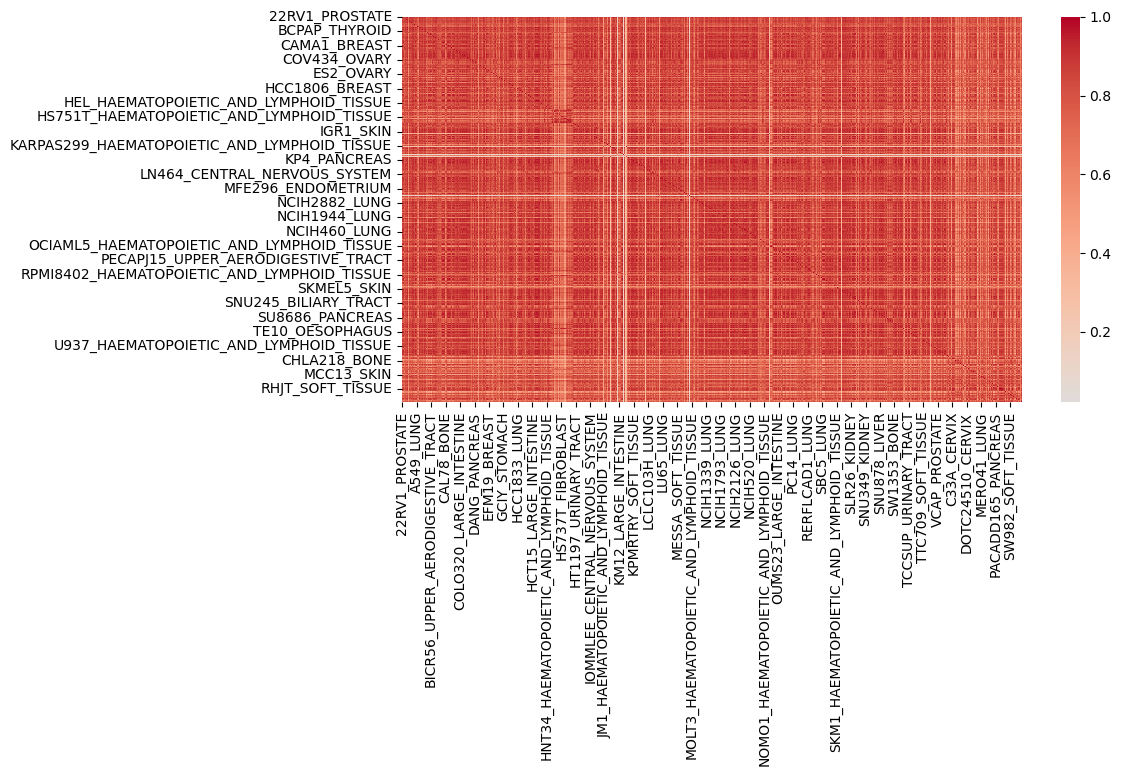

In [25]:
plt.figure(figsize=(10,5))
#df_small = df.iloc[:, :50]
#c= df_small.corr()
c= expr.corr()
midpoint = (c.values.max() - c.values.min()) /2 + c.values.min()
#sns.heatmap(c,cmap='coolwarm',annot=True, center=midpoint )
sns.heatmap(c,cmap='coolwarm', center=0 )
print("Number of cells included: ", np.shape(c))
print("Average correlation of expression profiles between cells: ", midpoint)
print("Min. correlation of expression profiles between cells: ", c.values.min())

We could look at the distribution of the correlation between gene expression profiles using Histogram

In [1]:
np.shape(c)
type(c)
c.head(3)
c_small=c.iloc[:,:3]
sns.histplot(c_small,bins=100)
plt.ylabel('Frequency')
plt.xlabel('Correlation between cells expression profiles')

NameError: name 'np' is not defined

Filter for tp53


f

### Feature Selection

## CELLINE CCLE BROAD 